# Segment Anything

In [1]:
import matplotlib.pyplot as plt
from skimage import io
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [4]:
import os.path as op
IMG_DIR = op.expanduser("/Users/bao/Dropbox/Manuscripts/GRABSEEDS/leaf_example")

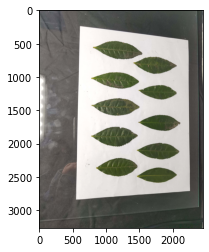

In [118]:
test_img = io.imread(op.join(IMG_DIR, "tea1_ZB1H.jpg"))
plt.imshow(test_img)

In [96]:
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint="./sam_vit_h_4b8939.pth")

In [119]:
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(test_img)

Retained 13 masks out of 28
Retained 12 masks out of 13
0 1.0831421007945663
1 1.1096117879341278
2 1.2100964773164167
3 1.2845870578623606
4 1.3008693571382801
5 1.3250612745098038
6 1.4128430171088044
7 1.4233933463091117
8 1.5293722166154042
9 1.5738012423106498
10 1.6302824234268871
11 3.7185092071959502


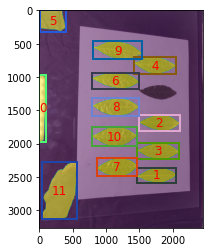

In [122]:
import numpy as np

# def is_overlapping(mask1, mask2, threshold=0.5):
#     """Check if mask1 overlaps with mask2 more than the given threshold."""
#     intersection = np.sum(mask1 & mask2)
#     return intersection / min(np.sum(mask1), np.sum(mask2)) > threshold

def is_overlapping(mask1, mask2, threshold=0.5):
    """Check if bounding boxes of mask1 and mask2 overlap more than the given
    threshold."""
    x1, y1, w1, h1 = mask1["bbox"]
    x2, y2, w2, h2 = mask2["bbox"]
    x_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    y_overlap = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
    intersection = x_overlap * y_overlap
    return intersection / min(w1 * h1, w2 * h2) > threshold


def deduplicate_masks(masks, threshold=0.5):
    """Deduplicate masks to retain only the foreground objects."""
    masks_sorted = sorted(
        masks, key=lambda x: x["area"]
    )
    retained_masks = []

    for mask in masks_sorted:
        # current_segmentation = mask["segmentation"]
        if not any(
            is_overlapping(
                mask, retained_mask, threshold
            )
            for retained_mask in retained_masks
        ):
            retained_masks.append(mask)
    print(f"Retained {len(retained_masks)} masks out of {len(masks)}")
    return retained_masks

import random

def random_color():
    """Generate a random color."""
    return [random.random() for _ in range(3)]


image_size = test_img.shape[0] * test_img.shape[1]
filtered_masks = [mask for mask in masks if 0.01 * image_size < mask["area"] < 0.5 * image_size]
print(f"Retained {len(filtered_masks)} masks out of {len(masks)}")
deduplicated_masks = deduplicate_masks(filtered_masks)

fig, ax = plt.subplots()
ax.imshow(test_img)
total_mask = np.zeros_like(test_img[:, :, 0])
labels = np.zeros_like(test_img[:, :, 0])
for i, mask in enumerate(deduplicated_masks):
    # if i != 2:
    #     continue
    segmentation = mask["segmentation"]
    # get the bounding box from segmentation
    y, x = np.where(segmentation)
    x, y, w, h = np.min(x), np.min(y), np.max(x) - np.min(x), np.max(y) - np.min(y)
    total_mask |= mask["segmentation"]
    labels[segmentation] = i + 1
    # x, y, w, h = mask["bbox"]
    # compute bounding box from segmentation
    # plot bounding box
    rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=random_color(), facecolor="none")
    ax.add_patch(rect)
    area = mask["area"]
    print(i, area / image_size * 100)
    midx, midy = x + w  / 2, y + h / 2
    ax.text(midx, midy, i, fontsize=12, color="red", ha="center", va="center")
    # ax.imshow(segmentation, alpha=0.5)
ax.imshow(total_mask, alpha=0.5)
plt.show()

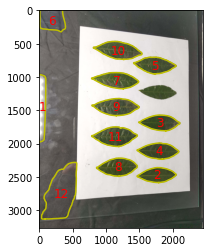

In [123]:
from skimage.measure import find_contours, regionprops
from math import pi

fig, ax = plt.subplots()
rp = regionprops(labels)
for i, props in enumerate(rp):
    i += 1
    ax.imshow(labels == i, alpha=0.5)
    contour = find_contours(labels == props.label, 0.5)[0]
    y0, x0 = props.centroid
    circularity = 4 * pi * props.area / props.perimeter**2
    ax.text(x0, y0, f"{i}", fontsize=12, color="red", ha="center", va="center")
    orientation = props.orientation
    ax.plot(contour[:, 1], contour[:, 0], "y-")
ax.imshow(test_img)
plt.show()

Followup ideas:

- Remove segments that are close to boundaries
- Look into segment 2 that have a faulty bbox